In [1]:
import csv
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

from io import StringIO
import requests

In [2]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [3]:
def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [4]:
df_train_dev = load_dataset(url_train_dev)
df_test = load_dataset(url_test)

In [5]:
df_train_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52675 entries, 0 to 52674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   52675 non-null  object
 1   label   52675 non-null  object
dtypes: object(2)
memory usage: 823.2+ KB


In [6]:
df_train_dev.head()

,tweet,label
0,يا من أناديها ويخنقني البكاء ويكاد صمت الدمع ...,ar
1,فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...,ar
2,ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...,ar
3,يا ابو سلو عرفتني,ar
4,ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله م...,ar


In [7]:
un_labels = df_train_dev.label.unique()
print(un_labels)
un_labels_count = len(un_labels)
un_labels_count

['ar' 'ar_LATN' 'az' 'bg' 'bn' 'bs' 'ca' 'cs' 'cy' 'da' 'de' 'dv' 'el'
 'en' 'es' 'et' 'fa' 'fi' 'fr' 'gl' 'ha' 'he' 'hi' 'hi-Latn' 'hr' 'ht'
 'hu' 'hy' 'id' 'is' 'it' 'ja' 'ja_LATN' 'jv' 'km' 'ko' 'ko_LATN' 'ms'
 'ne' 'nl' 'no' 'pl' 'ps' 'ps_LATN' 'pt' 'ro' 'ru' 'si' 'sl' 'sq' 'sr'
 'su' 'sv' 'sw' 'ta' 'ta_LATN' 'th' 'tl' 'tn' 'tr' 'uk' 'und' 'ur'
 'ur_LATN' 'vi' 'wo' 'xh' 'zh-CN' 'zh-TW']


69

In [8]:
X_train = df_train_dev.tweet
y_train = df_train_dev.label
X_test = df_test.tweet
y_test = df_test.label

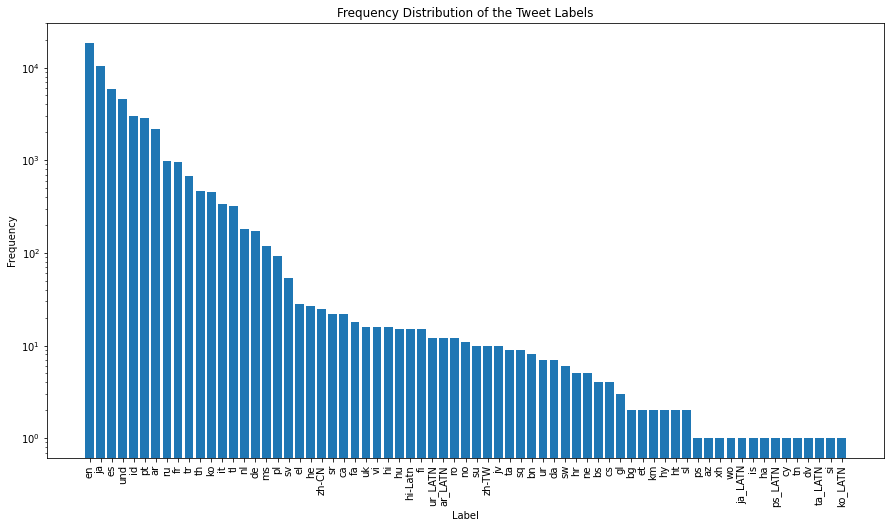

In [9]:
#plotting the frequency distribution of the various tweet languages
freq_lang = y_train.value_counts().to_dict()
plt.figure(figsize=(15,8))
plt.bar(freq_lang.keys(),freq_lang.values())
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.yscale('log')
plt.xticks(rotation=90)
plt.title("Frequency Distribution of the Tweet Labels")
plt.show()

In [10]:
#calculating the length of the tweets
def length(text):
  return len(text)
df_train_dev["tweet_length"] = X_train.apply(length)

#get average word length for a given tweet
def get_average_word_length(text):
  text_list=[len(word) for word in text.split()]
  mean=np.ceil(np.mean(text_list))
  return mean
df_train_dev["avg_word_length"] = X_train.apply(get_average_word_length)

#get max word length for a given sentence
def get_max_wordlength(text):
  text_list=[len(word) for word in text.split()]
  max=np.ceil(np.max(text_list))
  return max
df_train_dev["max_word_length"]=X_train.apply(get_max_wordlength)

#get count of spaces in the given tweet
def get_total_spaces(text):
  return text.count(" ")

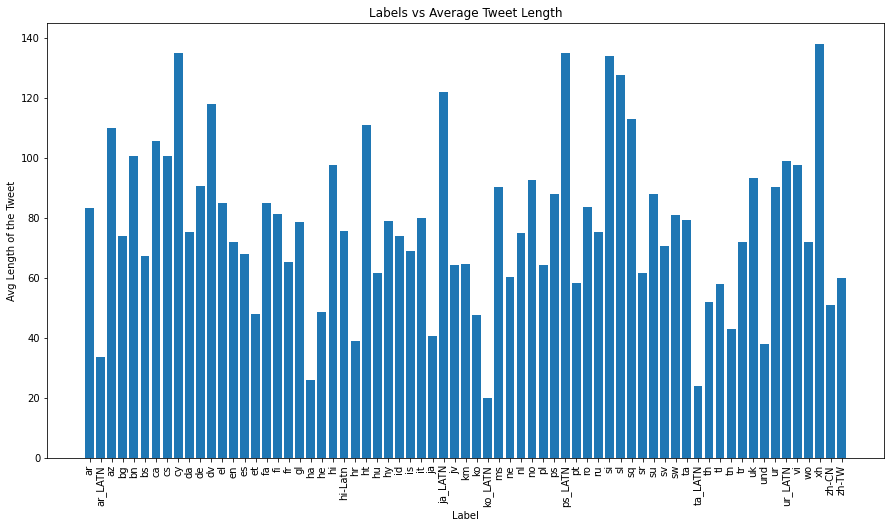

In [11]:
#plot average length of sentences for each language
df_train_grouped=df_train_dev.groupby('label')["tweet_length"].mean().to_dict()

plt.figure(figsize=(15,8))
plt.bar(df_train_grouped.keys(),df_train_grouped.values())
plt.xlabel("Label")
plt.ylabel("Avg Length of the Tweet")
plt.xticks(rotation=90)
plt.title("Labels vs Average Tweet Length")
plt.show()

In [12]:
#getting 5 languages with longest average word lenght
sorted(zip(df_train_grouped.values(), df_train_grouped.keys()), reverse = True)[:5]

[(138.0, 'xh'),
 (135.0, 'ps_LATN'),
 (135.0, 'cy'),
 (134.0, 'si'),
 (127.5, 'sl')]

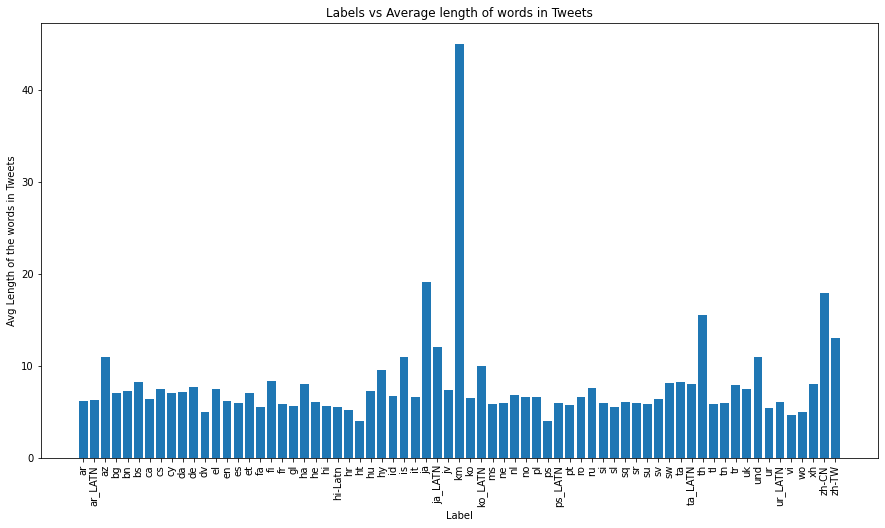

In [13]:
#plot average word length for each language
df_train_grouped=df_train_dev.groupby('label')["avg_word_length"].mean().to_dict()

plt.figure(figsize=(15,8))
plt.bar(df_train_grouped.keys(),df_train_grouped.values())
plt.xlabel("Label")
plt.ylabel("Avg Length of the words in Tweets")
plt.xticks(rotation=90)
plt.title("Labels vs Average length of words in Tweets")
plt.show()

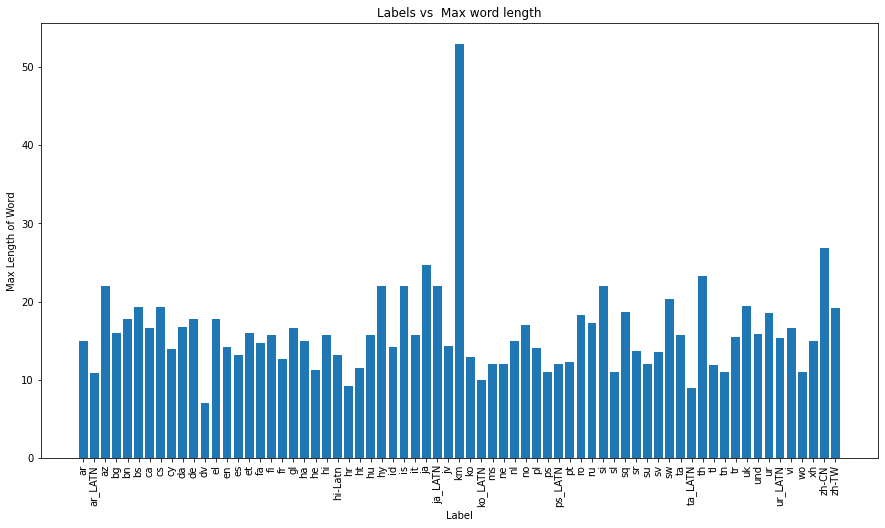

In [14]:
#plot max word length for each language
df_train_grouped = df_train_dev.groupby('label')["max_word_length"].mean().to_dict()

plt.figure(figsize=(15,8))
plt.bar(df_train_grouped.keys(),df_train_grouped.values())
plt.xlabel("Label")
plt.ylabel("Max Length of Word")
plt.xticks(rotation=90)
plt.title("Labels vs  Max word length")
plt.show()

In [15]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import re
import string
import emoji
exclude = string.punctuation

#lowercasing, removing html tags, urlss, punctuations and emojis
def convert_lowercase(column):
    column = column.str.lower()
    return column

def remove_html_tags(text):
    re_html = re.compile('<.*?>')
    return re_html.sub(r'', text)

def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

def remove_special(text):
    x=''
    for i in text:
        if i.isalnum():
            x=x+i
        else:
            x=x+' '
    return x

def remove_digits(text):
    filtered_string = ''.join((x for x in text if not x.isdigit()))
    return filtered_string

def remove_pattern(text):
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    return text
    

In [17]:
def get_num_features(data):

  data["tweet_length"] = data["tweet"].apply(length)
  data["max_word_length"] = data["tweet"].apply(get_max_wordlength)
  data["avg_word_length"] = data["tweet"].apply(get_average_word_length)
  data["space_count"] = data["tweet"].apply(get_total_spaces)

  scaler = preprocessing.StandardScaler()
  data[["tweet_length","max_word_length","avg_word_length","space_count"]] = scaler.fit_transform(data[["tweet_length","max_word_length","avg_word_length","space_count"]])

  return data

In [18]:
#data preprocessing and extracting numerical features
def preprocess_data(data):

  data = get_num_features(data)

  #preprocessing
  data["tweet"] = convert_lowercase(data["tweet"])
  data["tweet"] = data["tweet"].apply(remove_pattern)
  data["tweet"] = data["tweet"].apply(remove_html_tags)
  data["tweet"] = data["tweet"].apply(remove_url)
  data["tweet"] = data["tweet"].apply(remove_digits)
  data["tweet"] = data["tweet"].apply(remove_punc)
  data["tweet"] = data["tweet"].apply(emoji.demojize)
  data["tweet"] = data["tweet"].apply(remove_special)

  return data


In [19]:
#vectorizing labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
le_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_mapping)

{'ar': 0, 'ar_LATN': 1, 'az': 2, 'bg': 3, 'bs': 4, 'ca': 5, 'cs': 6, 'da': 7, 'de': 8, 'el': 9, 'en': 10, 'es': 11, 'eu': 12, 'fa': 13, 'fi': 14, 'fr': 15, 'he': 16, 'hi': 17, 'hi-Latn': 18, 'hr': 19, 'ht': 20, 'id': 21, 'it': 22, 'ja': 23, 'ja_LATN': 24, 'jv': 25, 'km': 26, 'ko': 27, 'ko_LATN': 28, 'la': 29, 'lv': 30, 'mk': 31, 'mn': 32, 'mr': 33, 'ms': 34, 'nl': 35, 'no': 36, 'pl': 37, 'pt': 38, 'ro': 39, 'ru': 40, 'sk': 41, 'sr': 42, 'sv': 43, 'sw': 44, 'ta': 45, 'ta_LATN': 46, 'th': 47, 'tl': 48, 'tr': 49, 'uk': 50, 'und': 51, 'ur': 52, 'ur_LATN': 53, 'vi': 54, 'xh': 55, 'yo': 56, 'zh-CN': 57, 'zh-TW': 58, 'zu': 59}


**Logistic Regression**

In [20]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = .90)

vectorizer = TfidfVectorizer(smooth_idf=True, ngram_range=(1,1), analyzer='char')

# construct the column transfomer
column_transformer = ColumnTransformer([
    ('vect', vectorizer, 'tweet')], 
    remainder='passthrough')

pipe = Pipeline([
    ('vect', column_transformer),
    ("clf", LogisticRegression(max_iter=10))
    ])

param_grid = [{
     'clf__penalty': ['l2','none'], 'clf__solver': ['newton-cg', 'sag']
}]

gs_lr = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, verbose=1, n_jobs = 4)
gs_lr.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % gs_lr.best_score_)
print(gs_lr.best_params_)
print("Validation Acuracy: ",gs_lr.score(X_val, y_val))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Best parameter (CV score=0.819):
{'clf__penalty': 'none', 'clf__solver': 'newton-cg'}
Validation Acuracy:  0.8227031131359149


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


In [21]:
best_model = Pipeline([
    ('vect', column_transformer),
    ("clf", LogisticRegression(max_iter=10, penalty = 'none', solver = 'newton-cg'))
    ])
best_model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('vect',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vect',
                                                  TfidfVectorizer(analyzer='char'),
                                                  'tweet')])),
                ('clf',
                 LogisticRegression(max_iter=10, penalty='none',
                                    solver='newton-cg'))])

In [22]:
from sklearn.metrics import accuracy_score

y_pred = best_model.predict(X_test)

print('Test Accuracy: ', accuracy_score(y_pred , y_test))

Test Accuracy:  0.0385571202650802


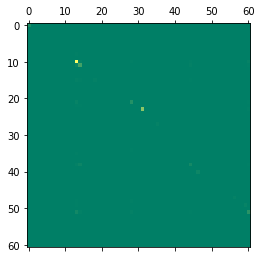

In [23]:
conf_mx = confusion_matrix(y_test, y_pred)
plt.matshow(conf_mx, cmap=plt.cm.summer)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


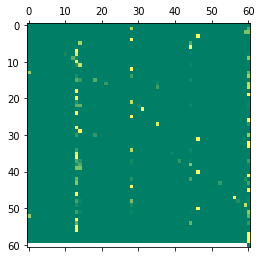

In [24]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.summer)
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       529
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00        50
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00      4758
          11       0.00      0.00      0.00      1476
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00       224
          16       0.00      0.00      0.00        14
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [26]:
pip install -U eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
enc_list=[le_mapping['en'],le_mapping['es'],le_mapping['ja']]

In [28]:
import eli5
from eli5 import show_weights

# inspect model weights
eli5.show_weights(best_model, top=10, targets=enc_list)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
